# diffusion model based image generation and maintenance

# papers and references
- https://paperswithcode.com/task/text-to-image-generation
- https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946/

# attempt

flower image dataset
- https://www.kaggle.com/datasets/aksha05/flower-image-dataset

In [1]:
# import kagglehub
# path = kagglehub.dataset_download("aksha05/flower-image-dataset")
# print("Path to dataset files:", path)

2025-05-08 14:35:39.093808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746714939.271209      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746714939.322318      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

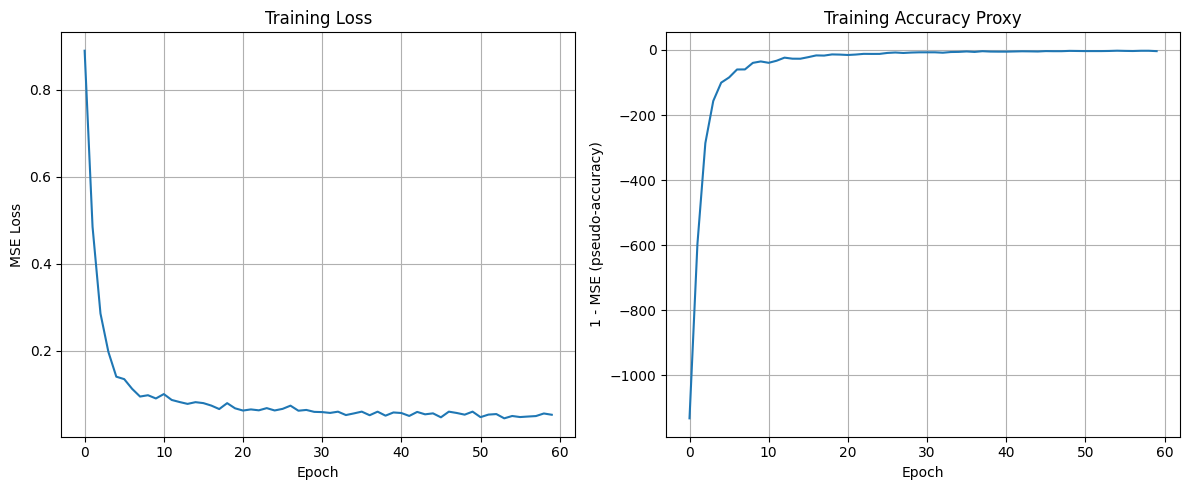

In [2]:
import os
import math
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython.display import HTML

# transformers for CLIP text conditioning
from transformers import CLIPTokenizer, CLIPTextModel

class FlowerDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.classes = sorted({f.split('_')[0] for f in self.image_files})
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        path = os.path.join(self.image_dir, fname)
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_name = fname.split('_')[0]
        label = self.class_to_idx[label_name]
        return img, label

# ----- Configuration -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
epochs = 60
scale = 5
lr = 2e-4
image_size = 80
channels = 3           # RGB
T = 1000
time_emb_dim = 128
text_emb_dim = 512
cond_drop_prob = 0.1

beta_start, beta_end = 1e-4, 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1. - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)
alpha_cumprod_prev = F.pad(alpha_cumprod[:-1], (1,0), value=1.0)
def extract(a, t, x_shape):
    out = a.gather(-1, t)
    return out.view(-1, *([1] * (len(x_shape) - 1)))

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(
            -torch.log(torch.tensor(10000.0)) * torch.arange(0, half, device=device) / half
        )
        args = t[:, None].float() * freqs[None]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return emb  # (B, dim)

class CondDropout(nn.Module):
    def __init__(self, drop_prob):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, emb):
        if not self.training or self.drop_prob == 0.:
            return emb
        mask = (torch.rand(emb.size(0), device=emb.device) > self.drop_prob).float()
        return emb * mask[:, None]

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, desired_groups=8):
        super().__init__()
        # pick valid group counts via GCD
        g1 = math.gcd(in_ch, desired_groups)
        g2 = math.gcd(out_ch, desired_groups)
        self.time_proj = nn.Linear(time_dim, out_ch)
        self.block = nn.Sequential(
            nn.GroupNorm(g1, in_ch),
            nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(g2, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block(x)
        t = self.time_proj(t_emb)[:, :, None, None]
        h = h + t
        return h + self.res_conv(x)

class CrossAttention(nn.Module):
    def __init__(self, channels, text_dim, num_heads=4):
        super().__init__()
        self.norm = nn.GroupNorm(1, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Linear(text_dim, channels)
        self.v = nn.Linear(text_dim, channels)
        self.proj = nn.Conv2d(channels, channels, 1)
        self.num_heads = num_heads
        self.head_dim = channels // num_heads

    def forward(self, x, text_emb):
        B, C, H, W = x.shape
        xn = self.norm(x)
        q = self.q(xn).view(B, self.num_heads, self.head_dim, H*W)
        k = self.k(text_emb).view(B, self.num_heads, self.head_dim, -1)
        v = self.v(text_emb).view(B, self.num_heads, self.head_dim, -1)
        attn = torch.einsum('b h d n, b h d m -> b h n m', q, k) / (self.head_dim**0.5)
        attn = torch.softmax(attn, dim=-1)
        out = torch.einsum('b h n m, b h d m -> b h d n', attn, v)
        out = out.reshape(B, C, H, W)
        return x + self.proj(out)

class SelfAttention(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.norm = nn.GroupNorm(1, channels)
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads, batch_first=True)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        xf = self.norm(x).view(B, C, H*W).permute(0,2,1)
        out, _ = self.attn(xf, xf, xf)
        out = out.permute(0,2,1).view(B, C, H, W)
        return x + self.proj(out)

# ----- 7. Down / Up blocks -----
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, text_dim=None, attn=False):
        super().__init__()
        self.res1 = ResidualBlock(in_ch, out_ch, time_dim)
        self.attn = CrossAttention(out_ch, text_dim) if attn else None
        self.res2 = ResidualBlock(out_ch, out_ch, time_dim)
        self.down = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)

    def forward(self, x, t_emb, text_emb=None):
        x = self.res1(x, t_emb)
        if self.attn is not None:
            x = self.attn(x, text_emb)
        x = self.res2(x, t_emb)
        return x, self.down(x)

class UpBlock(nn.Module):
    def __init__(self, up_in_ch, skip_ch, out_ch, time_dim, text_dim=None, attn=False):
        super().__init__()
        self.up = nn.ConvTranspose2d(up_in_ch, out_ch, 4, stride=2, padding=1)
        # after up: channels = out_ch; after concat: channels = out_ch + skip_ch
        self.res1 = ResidualBlock(out_ch + skip_ch, out_ch, time_dim)
        self.attn = CrossAttention(out_ch, text_dim) if attn else None
        self.res2 = ResidualBlock(out_ch, out_ch, time_dim)

    def forward(self, x, skip, t_emb, text_emb=None):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.res1(x, t_emb)
        if self.attn is not None:
            x = self.attn(x, text_emb)
        x = self.res2(x, t_emb)
        return x

# ----- Full Text-Guided UNet -----
class TextGuidedUNet(nn.Module):
    def __init__(self,
                 img_ch=3,
                 base_ch=64,
                 time_dim=128,
                 text_dim=512,
                 cond_drop_prob=0.1,
                 num_heads=4):
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim*4),
            nn.SiLU(),
            nn.Linear(time_dim*4, time_dim),
        )
        self.cond_dropout = CondDropout(cond_drop_prob)

        # encoder
        self.down1 = DownBlock(img_ch,       base_ch,     time_dim, text_dim, attn=True)
        self.down2 = DownBlock(base_ch,      base_ch*2,   time_dim, text_dim, attn=True)

        # bottleneck
        self.bot_res1 = ResidualBlock(base_ch*2, base_ch*4, time_dim)
        self.bot_attn = SelfAttention(base_ch*4, num_heads)
        self.bot_res2 = ResidualBlock(base_ch*4, base_ch*2, time_dim)

        # decoder (note skip channels)
        self.up2 = UpBlock(base_ch*2, base_ch*2, base_ch,     time_dim, text_dim, attn=True)
        self.up1 = UpBlock(base_ch,    base_ch,    base_ch,     time_dim, text_dim, attn=True)

        # final
        self.out = nn.Sequential(
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, img_ch, 1)
        )

    def forward(self, x, t, text_emb):
        t = t.long()
        t_emb = self.time_emb(t)
        text_emb = self.cond_dropout(text_emb)

        d1, x = self.down1(x, t_emb, text_emb)
        d2, x = self.down2(x, t_emb, text_emb)

        x = self.bot_res1(x, t_emb)
        x = self.bot_attn(x)
        x = self.bot_res2(x, t_emb)

        x = self.up2(x, d2, t_emb, text_emb)
        x = self.up1(x, d1, t_emb, text_emb)
        return self.out(x)

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])
dataset_path = '/kaggle/input/flower-image-dataset/flowers'
train_ds = FlowerDataset(dataset_path, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

tokenizer    = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
for p in text_encoder.parameters():
    p.requires_grad = False
text_encoder.eval()
with torch.no_grad():
    lbls = train_ds.classes
    txt = tokenizer(lbls, padding=True, return_tensors="pt").to(device)
    label_embs = text_encoder(**txt).last_hidden_state[:,0,:]  # (num_classes, 512)

model = TextGuidedUNet(
    img_ch=channels,
    base_ch=64,
    time_dim=time_emb_dim,
    text_dim=text_emb_dim,
    cond_drop_prob=cond_drop_prob,
    num_heads=4
).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

loss_hist = []
acc_hist = []

for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    total_loss = 0.0
    total_mse = 0.0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        b = imgs.size(0)
        t = torch.randint(0, T, (b,), device=device)

        noise = torch.randn_like(imgs)
        a_bar = extract(alpha_cumprod, t, imgs.shape)
        xt = torch.sqrt(a_bar) * imgs + torch.sqrt(1 - a_bar) * noise

        txt_emb = label_embs[labels].to(device)
        pred = model(xt, t, txt_emb)

        loss = F.mse_loss(pred, noise)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * b

        # Compute pseudo-accuracy (1 - MSE between predicted x0 and original image)
        with torch.no_grad():
            x0_pred = (xt - torch.sqrt(1 - a_bar) * pred) / torch.sqrt(a_bar)
            mse = F.mse_loss(x0_pred, imgs)
            total_mse += mse.item() * b

    epoch_loss = total_loss / len(train_ds)
    epoch_acc = 1.0 - (total_mse / len(train_ds))

    loss_hist.append(epoch_loss)
    acc_hist.append(epoch_acc)

    # Append accuracy to a file
    with open("accuracy_log.txt", "a") as f:
        f.write(f"Epoch {epoch+1}: Accuracy ≈ {epoch_acc:.6f}\n")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.title("Training Loss")

plt.subplot(1,2,2)
plt.plot(acc_hist)
plt.xlabel("Epoch")
plt.ylabel("1 - MSE (pseudo-accuracy)")
plt.grid(True)
plt.title("Training Accuracy Proxy")

plt.tight_layout()
plt.show()

@torch.no_grad()
def p_sample(x_t, t, cond_emb, uncond_emb, scale):
    b = x_t.size(0)
    t_b = torch.full((b,), t, device=device, dtype=torch.long)
    e_cond   = model(x_t, t_b, cond_emb)
    e_uncond = model(x_t, t_b, uncond_emb)
    e = e_uncond + scale * (e_cond - e_uncond)

    a_t    = extract(alphas,          t_b, x_t.shape)
    a_bar  = extract(alpha_cumprod,   t_b, x_t.shape)
    a_prev = extract(alpha_cumprod_prev, t_b, x_t.shape)
    b_t    = extract(betas,           t_b, x_t.shape)

    x0 = (x_t - torch.sqrt(1 - a_bar)*e) / torch.sqrt(a_bar)
    coef1 = b_t * torch.sqrt(a_prev) / (1 - a_bar)
    coef2 = torch.sqrt(a_t) * (1 - a_prev) / (1 - a_bar)
    mu    = coef1 * x0 + coef2 * x_t
    var   = b_t * (1 - a_prev) / (1 - a_bar)
    return mu + torch.sqrt(var) * torch.randn_like(x_t) if t > 0 else mu

@torch.no_grad()
def sample_with_intermediates(prompt, scale):
    txt = tokenizer([prompt], padding=True, return_tensors="pt").to(device)
    c_emb = text_encoder(**txt).last_hidden_state[:,0,:]
    empty = tokenizer([""], padding=True, return_tensors="pt").to(device)
    u_emb = text_encoder(**empty).last_hidden_state[:,0,:]

    x = torch.randn((1, channels, image_size, image_size), device=device)
    intermediates = []
    for t in reversed(range(T)):
        x = p_sample(x, t, c_emb, u_emb, scale)
        frame = ((x + 1) / 2).cpu().squeeze().clamp(0,1).numpy()
        intermediates.append(frame)
    return x.clamp(-1,1), np.stack(intermediates, axis=0)


In [3]:
!cat "accuracy_log.txt"

Epoch 1: Accuracy ≈ -1132.450233
Epoch 2: Accuracy ≈ -596.412787
Epoch 3: Accuracy ≈ -286.451960
Epoch 4: Accuracy ≈ -156.782681
Epoch 5: Accuracy ≈ -100.465408
Epoch 6: Accuracy ≈ -84.475683
Epoch 7: Accuracy ≈ -60.018494
Epoch 8: Accuracy ≈ -59.807693
Epoch 9: Accuracy ≈ -39.677037
Epoch 10: Accuracy ≈ -35.298698
Epoch 11: Accuracy ≈ -39.493457
Epoch 12: Accuracy ≈ -33.116618
Epoch 13: Accuracy ≈ -23.624441
Epoch 14: Accuracy ≈ -26.804071
Epoch 15: Accuracy ≈ -26.936074
Epoch 16: Accuracy ≈ -22.115120
Epoch 17: Accuracy ≈ -16.750530
Epoch 18: Accuracy ≈ -17.283418
Epoch 19: Accuracy ≈ -13.703091
Epoch 20: Accuracy ≈ -14.247202
Epoch 21: Accuracy ≈ -15.460778
Epoch 22: Accuracy ≈ -14.088503
Epoch 23: Accuracy ≈ -11.983952
Epoch 24: Accuracy ≈ -12.164458
Epoch 25: Accuracy ≈ -12.109935
Epoch 26: Accuracy ≈ -9.108986
Epoch 27: Accuracy ≈ -7.808647
Epoch 28: Accuracy ≈ -9.252704
Epoch 29: Accuracy ≈ -7.951980
Epoch 30: Accuracy ≈ -7.256804
Epoch 31: Accuracy ≈ -7.218395
Epoch 32: Accurac

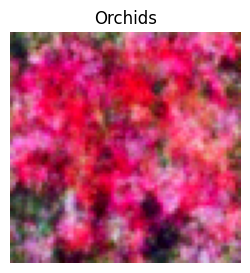

In [4]:
prompt = "Orchids"  # your prompt
final_img, inter = sample_with_intermediates(prompt, scale)

# Show final image (RGB)
to_img = lambda x: ((x+1)/2).cpu().squeeze().clamp(0,1).permute(1,2,0)  # <-- permute channels last
plt.figure(figsize=(3,3))
plt.imshow(to_img(final_img))  
plt.title(prompt); plt.axis('off')
plt.show()


In [ ]:
from matplotlib import animation
from IPython.display import HTML
# Inline JS animation (RGB)
frames = inter.transpose(0,2,3,1)  # <-- reshape from (T,3,<image size>,<image size>) to (T,<image size>,<image size>,3)
fig = plt.figure(figsize=(3,3))
im = plt.imshow(frames[0], animated=True) 
plt.axis('off')

def update(i):
    im.set_array(frames[i])
    return [im]

T = len(frames)

animated = animation.FuncAnimation(fig, update, frames=T, interval=20)
HTML(animated.to_jshtml())

## diffusion model saving 

In [6]:
torch.save(model, "text_to_image_flower_model.pth")

## diffusion model loading

In [7]:
# Loading model directly 
saved_model = torch.load("text_to_image_flower_model.pth", weights_only=False)
saved_model.to(device)
saved_model.eval()

TextGuidedUNet(
  (time_emb): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): SiLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
  (cond_dropout): CondDropout()
  (down1): DownBlock(
    (res1): ResidualBlock(
      (time_proj): Linear(in_features=128, out_features=64, bias=True)
      (block): Sequential(
        (0): GroupNorm(1, 3, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): GroupNorm(8, 64, eps=1e-05, affine=True)
        (4): SiLU()
        (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (res_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (attn): CrossAttention(
      (norm): GroupNorm(1, 64, eps=1e-05, affine=True)
      (q): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (k): Linear(in_features=512, out_features=64, bias=True)
      (v): Line

['bougainvillea', 'daisies', 'garden', 'gardenias', 'hibiscus', 'hydrangeas', 'lilies', 'orchids', 'peonies', 'tulip']


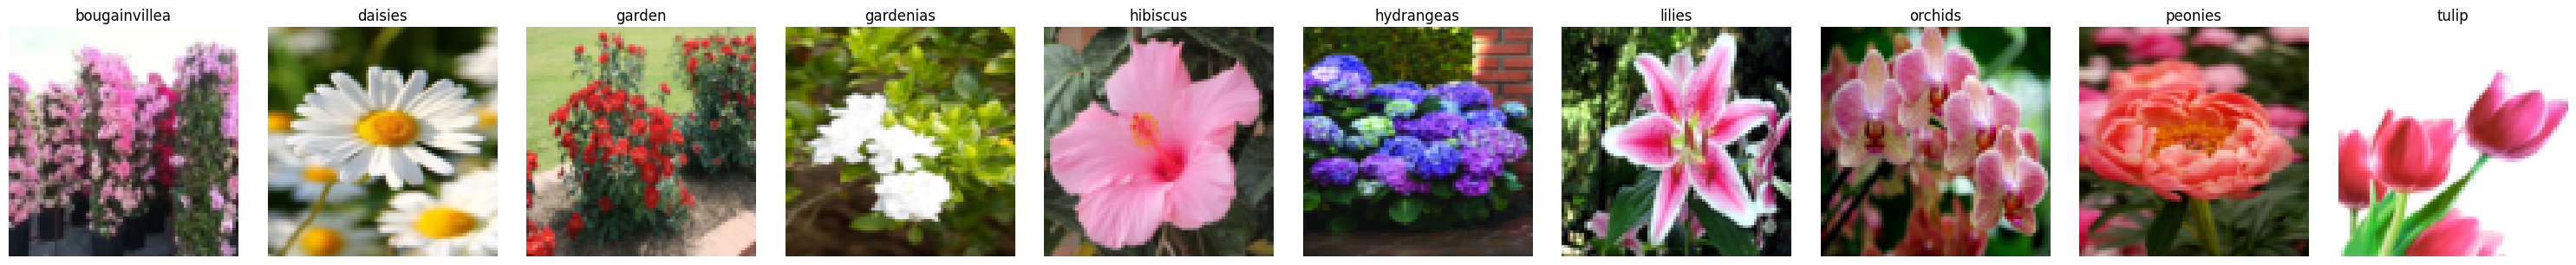

In [8]:
import random
import matplotlib.pyplot as plt

# Print class names
print(train_ds.classes)

# Map from class index to image paths
samples_per_class = {cls: None for cls in train_ds.classes}

# Randomly find one image per class
for img, label in train_ds:
    cls = train_ds.classes[label]
    if samples_per_class[cls] is None:
        samples_per_class[cls] = img
    if all(v is not None for v in samples_per_class.values()):
        break

# Plotting
fig, axs = plt.subplots(1, len(samples_per_class), figsize=(3*len(samples_per_class), 3))
if len(samples_per_class) == 1:
    axs = [axs]  # make iterable if only one class
for ax, (cls, img) in zip(axs, samples_per_class.items()):
    ax.imshow((img.permute(1, 2, 0) + 1) / 2)  # de-normalize if you used x*2-1
    ax.set_title(cls)
    ax.axis('off')

plt.tight_layout()
plt.show()
